In [1]:
import numpy as np
import pandas as pd
import cv2
import os
from torch.utils.data import Dataset, DataLoader
from tensorflow import keras
from tensorflow.keras import layers,models
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import DenseNet121, Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [2]:
class ImageLabelDataset(Dataset):
    def __init__(self, dataframe, image_dir):
        self.dataframe = dataframe
        self.image_dir = image_dir

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.dataframe.iloc[idx, 0])
        image = cv2.imread(img_name)
        label = self.dataframe.iloc[idx, 1]
        re_img = cv2.resize(image, (128, 128))
        gray_image = cv2.cvtColor(re_img, cv2.COLOR_BGR2GRAY)
    
        return re_img,gray_image, label

class ImageLabelDataset2(Dataset):
    def __init__(self, dataframe, image_dir):
        self.dataframe = dataframe
        self.image_dir = image_dir

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.dataframe.iloc[idx, 1])
        image = cv2.imread(img_name)
        label = self.dataframe.iloc[idx, 2]
        re_img = cv2.resize(image, (128,128))
        gray_image = cv2.cvtColor(re_img, cv2.COLOR_BGR2GRAY)
    
        return re_img,gray_image, label

In [3]:
test_df = pd.read_csv('test.csv')
train_df = pd.read_csv('train.csv')
train_ds = ImageLabelDataset(train_df,'Train')
test_ds = ImageLabelDataset2(test_df,'Test')
imgs = []
g_imgs =[]
labls = []
for row in train_ds:
    imgs.append(row[0])
    g_imgs.append(row[1])
    labls.append(row[2])

fin_tr_df = pd.DataFrame({"Image" : imgs,"G_image" : g_imgs, "Label" : labls})

imgs = []
g_imgs = []
labls = []
for row in test_ds:
    imgs.append(row[0])
    g_imgs.append(row[1])
    labls.append(row[2])

fin_te_df = pd.DataFrame({"Image" : imgs,"G_image" : g_imgs, "Label" : labls})

In [4]:
x_train = np.stack(fin_tr_df['Image'])
y_train = np.stack(fin_tr_df['Label'])
x_test = np.stack(fin_te_df['Image'])
y_test = np.stack(fin_te_df['Label'])


y_train = to_categorical(y_train, num_classes=20)
y_test = to_categorical(y_test, num_classes=20)

In [5]:
from tensorflow.keras.applications import ResNet50
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [6]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
def build_model(base_model):
    base_model.trainable = False
    model = models.Sequential([
        base_model,
        
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(20, activation='softmax')
    ])
    return model

augmentation = models.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.3),
    RandomZoom(0.2)
])

In [7]:
x_train_resized = tf.image.resize(x_train, (224, 224))
XXX = x_train_resized[:5000]
XXXV = x_train_resized[5000:]
YYY = y_train[:5000]
YYYV = y_train[5000:]
x_test_resized = tf.image.resize(x_test, (224, 224))
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224, 3))
resnet_model = build_model(resnet_base)

resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = resnet_model.fit(XXX, YYY, validation_data=(XXXV, YYYV), epochs=15, batch_size=64)

Epoch 1/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.2460 - loss: 2.6674 - val_accuracy: 0.6529 - val_loss: 1.3204
Epoch 2/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.5720 - loss: 1.4649 - val_accuracy: 0.7038 - val_loss: 0.9929
Epoch 3/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.6545 - loss: 1.1538 - val_accuracy: 0.7548 - val_loss: 0.8777
Epoch 4/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.6806 - loss: 1.0533 - val_accuracy: 0.7580 - val_loss: 0.8237
Epoch 5/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.7465 - loss: 0.8669 - val_accuracy: 0.7739 - val_loss: 0.7794
Epoch 6/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.7612 - loss: 0.8038 - val_accuracy: 0.7675 - val_loss: 0.7551
Epoch 7/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.7765 - loss: 0.7405 - val_accuracy: 0.7643 - val_loss: 0.7565
Epoch 8/15
79/79 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.7875 - loss: 0.6859 - val_accuracy: 0.8025 - val_loss:

In [8]:
test_loss, test_accuracy = resnet_model.evaluate(x_test_resized, y_test, batch_size=64)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 987ms/step - accuracy: 0.8210 - loss: 0.6149
Test Loss: 0.5875549912452698
Test Accuracy: 82.96%


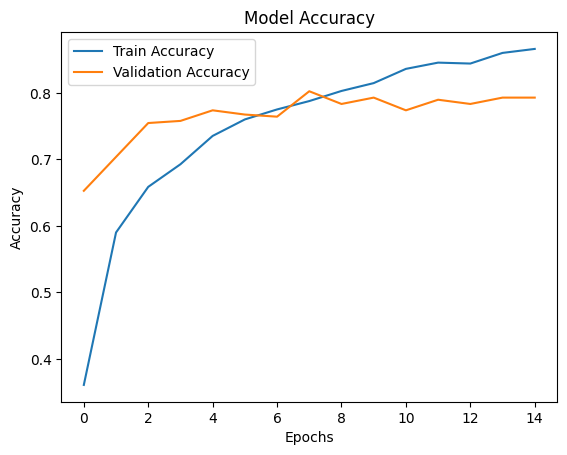

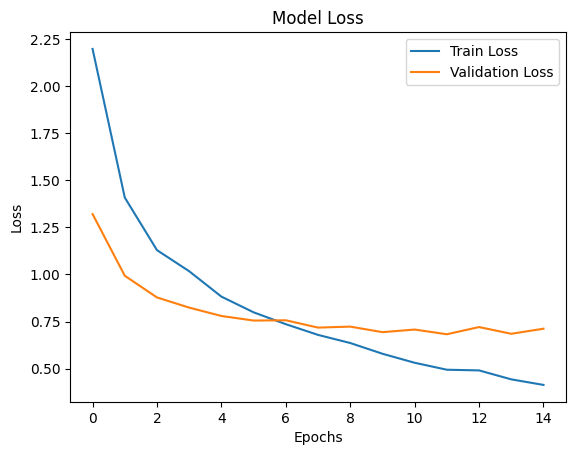

In [9]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
import numpy as np
import tensorflow as tf

def predict_label(image, model):
    if image.shape[:2] != (224,224):
        image = tf.image.resize(image, (224,224))

    # things = {
    #     0 : "It's a Burger",
    #     1,
    #     2,
    #     3,
    #     4,
    #     5,
    #     6,
    #     7,
    #     8,
    #     9,
    #     10,
    #     11,
    #     12,
    #     13,
    #     14,
    #     15,
    #     16,
    #     17,
    #     18,
    #     19 :
    # }

    image = np.expand_dims(image, axis=0)

    predictions = model.predict(image)
    
    predicted_index = np.argmax(predictions, axis=1)[0]

    return predicted_index

In [11]:
resnet_model.save('KIRAnet.h5')    